## Imports

In [63]:
% reset
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import nltk
import re
import gensim
from sklearn.model_selection import train_test_split
from helpers import *
from cleaners import *
from tfidf_w2v_helpers import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pathlib
from multiprocessing import Process
from pathlib import Path
from gensim.models import Word2Vec,TfidfModel,Phrases
from gensim.corpora import Dictionary
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import inspect
import itertools
from threading import Thread,Lock
from sklearn.neighbors import KNeighborsClassifier



%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Some helpers used to convert docs to vecs using tf weighted word2vec averaging

## cleaning the data without POS tagging

###  cleaning train and test data

In [64]:
basic_cleaned_root = speedy(basic_cleaner, ['aclImdb/train/pos','aclImdb/train/neg'],10,target_suffix='clean')

### creating training and validation set

In [65]:
X,y,wv_basic = tf_wv_samples(model_prefix='basic', root_dir=f'{basic_cleaned_root}train')

### Hyper parameter tuning of the classifiers

#### Hyper parameter tuning of logistic regression

In [15]:
def validate_svm(X, y, C):
    '''
       C: weight to the slack of the svm
       returns:
           best_svm: svm with the best accuracy
           clf_accs: accurcies of classifiers
           clf_vars: variance of k folds per classifier setting
    '''
    best_svm = None
    best_acc = 0
    clf_vars = []
    clf_accs = []
    for c in C:
        svm_clf = SVC(C=c) 
        accs = cross_val_score(svm_clf, X, y, n_jobs=-1)
        mean_acc, var_acc = np.mean(accs), np.var(accs)
        clf_accs.append(mean_acc)
        clf_vars.append(var_acc)
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_svm = svm_clf
    return best_svm, clf_accs, clf_vars


In [16]:
C = [0.1,5,10,15,20]
best_lr, lr_accs, lr_vars = cross_validate(X,y,classifier=LogisticRegression,parameters={'C':C,'solver':['lbfgs']},folds=10)

trained LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=N

In [16]:
def validate_random_forest(X, y, n_estimators):
    '''
       n_estimators: number of classifiers to try 
       
       returns:
           best_forest: svm with the best accuracy
           clf_accs: accurcies of classifiers
           clf_vars: variance of k folds per classifier setting
    '''
    best_forest = None
    best_acc = 0
    clf_vars = []
    clf_accs = []
    for n in n_estimators:
        forest_clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        accs = cross_val_score(forest_clf, X, y, n_jobs=-1)
        mean_acc, var_acc = np.mean(accs), np.var(accs)
        clf_accs.append(mean_acc)
        clf_vars.append(var_acc)
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_forest = svm_clf
    return best_forest, clf_accs, clf_vars

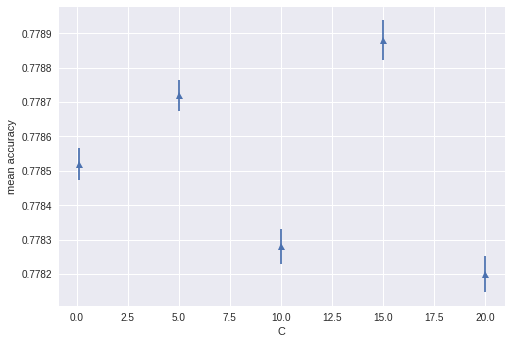

In [127]:
plt.errorbar(C, lr_accs, lr_vars, linestyle='None', marker='^')
plt.xlabel('C')
plt.ylabel('mean accuracy')
plt.show()

#### Hyper parameter tuning of RadnomForest

In [128]:
n_estimators = [50,100,200,300]
best_rf, rf_accs, rf_vars = cross_validate(X,y,classifier=RandomForestClassifier,parameters={'n_estimators':n_estimators,'max_depth':[5], 'n_jobs':[-1]},folds=10)

trained RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
trained RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
trained RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=

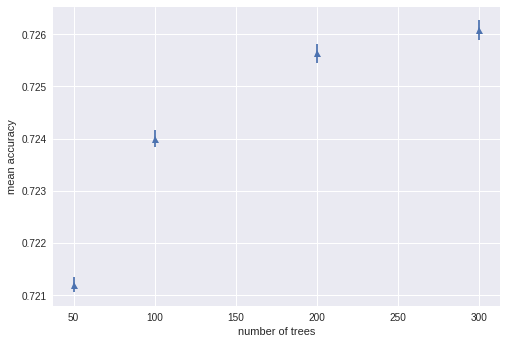

In [148]:
plt.errorbar(n_estimators, rf_accs, rf_vars, linestyle='None', marker='^')
plt.xlabel('number of trees')
plt.ylabel('mean accuracy')
plt.show()

In [147]:
best_nb, nb_accs, nb_vars = cross_validate(X,y,classifier=GaussianNB,folds=10)

trained GaussianNB(priors=None)


In [68]:
knn_neighbours = [3,5,11,13]
best_knn,knn_accs,knn_vars = cross_validate(X,y,classifier=KNeighborsClassifier,parameters={'n_neighbors':knn_neighbours},folds=10)

trained KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
trained KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
trained KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
trained KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')


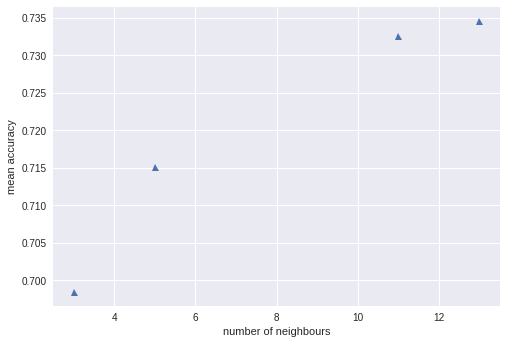

In [69]:
plt.errorbar(knn_neighbours, knn_accs, knn_vars, linestyle='None', marker='^')
plt.xlabel('number of neighbours')
plt.ylabel('mean accuracy')
plt.show()

### Accuracy on the test data

In [12]:
basic_cleaned_test = speedy(basic_cleaner,['aclImdb/test/pos','aclImdb/test/neg'],10,target_suffix='clean')

In [14]:
X_test,y_test,wv_basic = tf_wv_samples(model_prefix='basic_test', root_dir=f'{basic_cleaned_test}/test',wv=wv_basic)

In [19]:
best_lr.fit(X,y)
np.mean(best_lr.predict(X_test) == y_test)

0.77336000000000005

## POS tagged documents

In [20]:
pos_cleaned_root = speedy(pos_cleaner, ['aclImdb/train/pos','aclImdb/train/neg','aclImdb/train/unsup'],15,target_suffix='pos')

In [21]:
X,y,wv_pos = tf_wv_samples(model_prefix='pos', root_dir=f'{pos_cleaned_root}/train')

In [22]:
C = [0.1,5,10,15,20]
best_lr, lr_accs, lr_vars = cross_validate(X,y,classifier=LogisticRegression,parameters={'C':C,'solver':['lbfgs']},folds=10)

trained LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=N

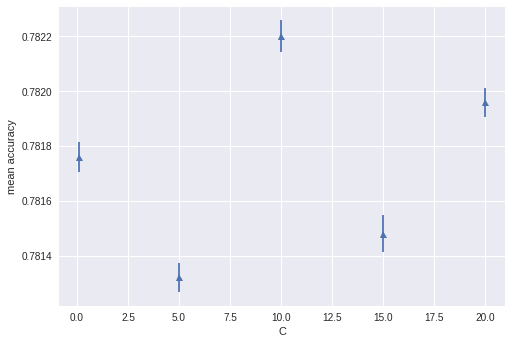

In [23]:
plt.errorbar(C, lr_accs, lr_vars, linestyle='None', marker='^')
plt.xlabel('C')
plt.ylabel('mean accuracy')
plt.show()

In [25]:
ada_estimators = [10,50,100]
best_ada, best_accs, best_var = cross_validate(X,y,AdaBoostClassifier, parameters={'n_estimators':ada_estimators,'base_estimator':[best_lr]},folds=10)

trained AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=10, random_state=None)
trained AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)
trained AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_cl

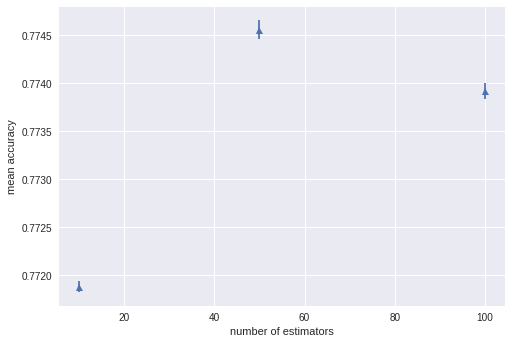

In [28]:
plt.errorbar(ada_estimators, best_accs, best_var, linestyle='None', marker='^')
plt.xlabel('number of estimators')
plt.ylabel('mean accuracy')
plt.show()

In [ ]:
bagging_estimators = [10,50,100]
best_bag, bag_accs, bag_var = cross_validate(X,y,BaggingClassifier, parameters={'n_estimators':bagging_estimators,'base_estimator':[best_lr]},folds=10)

trained BaggingClassifier(base_estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
trained BaggingClassifier(base_estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
trai

In [ ]:
best_bag

In [ ]:
basic_cleaned_test = speedy(basic_cleaner,['aclImdb/test/pos','aclImdb/test/neg'],10,target_suffix='pos')

## Google pre-trained word2vecs

In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  
basic_cleaned_root = speedy(basic_cleaner, ['aclImdb/train/pos','aclImdb/train/neg','aclImdb/train/unsup'],15,target_suffix='clean')
X,y = tf_wv_samples(model_prefix='google', root_dir=f'{basic_cleaned_root}/train')
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.33, random_state=42)

/home/alyswidan/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
clf = SVC(C=1)
clf.fit(X_train, y_train)
np.mean(clf.predict(X_val) == y_val)

0.7781818181818182

In [136]:
def x(**kwargs):
    for i in kwargs:
        print(i)
x(**{})